# CSE 572: Lab 4

In this lab, you will practice implementing k nearest neighbors for classification.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

Acknowledgment: Much of the content in this notebook was adapted from Introduction to Data Mining, 2nd Edition by Tan, Steinbach, Karpatne, Kumar.

## Dataset preparation

We will use the Wisconsin Breast Cancer Dataset for this exercise. We used the original version of the dataset for Lab 3 (found [here](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)), but for Lab 4 we will use a newer version of the dataset with different features. This dataset does not have any missing attribute values, so we ill skip cleaning it.

Read about this dataset here: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Description of dataset from UCI documentation: 

Number of instances: 569 

Number of attributes: 32 (ID, diagnosis, 30 real-valued input features)

Attribute information

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.  They describe characteristics of the cell nuclei present in the image. 

1. ID number
2. Diagnosis (M = malignant, B = benign)
3. Attributes 3-32:

Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)

The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, attribute 3 is Mean Radius, attribute 13
13 is Radius standard error, attribute 23 is Worst Radius.

In [28]:
# Load the original dataset
import pandas as pd
import numpy as np

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

data

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [29]:
# Drop the first column which represents the ID number
data = data.drop(columns=0)

# Rename column 1 to "class" since this column represents the class (M=malignant, B=benign)
data = data.rename(columns={1: "class"})

data

,class,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### Dataset splits

It is common practice in data mining and machine learning to split a dataset into training, validation, and test sets. 

- Training set: subset of dataset used for training/fitting model parameters
- Validation set: subset of dataset used to evaluate model generalization performance and tune hyperparameters (model choices)
- Test set: subset of dataset used to test performance after initial vetting using validation set

The training set is usually allocated the largest percentage of the total dataset. For example, a common split might be 60/20/20\% or 80/10/10\% of the data assigned to training/validation/test subsets respectively. 

This example shows how to split the dataset into training, validation, and test subsets using a simple random sampling strategy (without replacement). 

In [30]:
# Set the random seed
SEED = 42

In [31]:
# Sample 60% of the instances for the training set
train = data.sample(frac=0.6, random_state=SEED)
train

,class,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
204,B,12.47,18.60,81.09,481.9,0.09965,0.10580,0.08005,0.03821,0.1925,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750
70,M,18.94,21.31,123.60,1130.0,0.09009,0.10290,0.10800,0.07951,0.1582,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589
131,M,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019
431,B,12.40,17.68,81.47,467.8,0.10540,0.13160,0.07741,0.02799,0.1811,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359
540,B,11.54,14.44,74.65,402.9,0.09984,0.11200,0.06737,0.02594,0.1818,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,B,13.20,17.43,84.13,541.6,0.07215,0.04524,0.04336,0.01105,0.1487,...,13.94,27.82,88.28,602.0,0.1101,0.1508,0.2298,0.04970,0.2767,0.07198
375,B,16.17,16.07,106.30,788.5,0.09880,0.14380,0.06651,0.05397,0.1990,...,16.97,19.14,113.10,861.5,0.1235,0.2550,0.2114,0.12510,0.3153,0.08960
365,M,20.44,21.78,133.80,1293.0,0.09150,0.11310,0.09799,0.07785,0.1618,...,24.31,26.37,161.20,1780.0,0.1327,0.2376,0.2702,0.17650,0.2609,0.06735
433,M,18.82,21.97,123.70,1110.0,0.10180,0.13890,0.15940,0.08744,0.1943,...,22.66,30.93,145.30,1603.0,0.1390,0.3463,0.3912,0.17080,0.3007,0.08314


In [32]:
# Sample 20% for the validation set. 
# First we need to drop the training instances from our dataframe to sample from the remaining instances.
data_remaining = data.drop(train.index)
# Note that since we are sampling from the rows remaining after removing the training subset, which 
# leaves 40% of the total data, we need to sample 50% of the remaining dataset to result in 20% of 
# the original dataset.
val = data_remaining.sample(frac=0.5, random_state=SEED)
val

,class,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
522,B,11.26,19.83,71.30,388.1,0.08511,0.04413,0.005067,0.005664,0.1637,...,11.93,26.43,76.38,435.9,0.1108,0.07723,0.02533,0.02832,0.2557,0.07613
179,B,12.81,13.06,81.29,508.8,0.08739,0.03774,0.009193,0.013300,0.1466,...,13.63,16.15,86.70,570.7,0.1162,0.05445,0.02758,0.03990,0.1783,0.07319
28,M,15.30,25.27,102.40,732.4,0.10820,0.16970,0.168300,0.087510,0.1926,...,20.27,36.71,149.30,1269.0,0.1641,0.61100,0.63350,0.20240,0.4027,0.09876
485,B,12.45,16.41,82.85,476.7,0.09514,0.15110,0.154400,0.048460,0.2082,...,13.78,21.03,97.82,580.6,0.1175,0.40610,0.48960,0.13420,0.3231,0.10340
43,M,13.28,20.28,87.32,545.2,0.10410,0.14360,0.098470,0.061580,0.1974,...,17.38,28.00,113.10,907.2,0.1530,0.37240,0.36640,0.14920,0.3739,0.10270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,B,10.94,18.59,70.39,370.0,0.10040,0.07460,0.049440,0.029320,0.1486,...,12.40,25.58,82.76,472.4,0.1363,0.16440,0.14120,0.07887,0.2251,0.07732
385,M,14.60,23.29,93.97,664.7,0.08682,0.06636,0.083900,0.052710,0.1627,...,15.79,31.71,102.20,758.2,0.1312,0.15810,0.26750,0.13590,0.2477,0.06836
252,M,19.73,19.82,130.70,1206.0,0.10620,0.18490,0.241700,0.097400,0.1733,...,25.28,25.59,159.80,1933.0,0.1710,0.59550,0.84890,0.25070,0.2749,0.12970
105,M,13.11,15.56,87.21,530.2,0.13980,0.17650,0.207100,0.096010,0.1925,...,16.31,22.40,106.40,827.2,0.1862,0.40990,0.63760,0.19860,0.3147,0.14050


In [33]:
# Drop the validation instances from data_remaining
# This leaves us with the remaining 20% of the original dataset, 
# which makes up our test set.
test = data_remaining.drop(val.index)
test

,class,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
4,M,20.290,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.40000,0.16250,0.2364,0.07678
12,M,19.170,24.80,132.40,1123.0,0.09740,0.24580,0.20650,0.11180,0.2397,...,20.96,29.94,151.70,1332.0,0.1037,0.3903,0.36390,0.17670,0.3176,0.10230
13,M,15.850,23.95,103.70,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,...,16.84,27.66,112.00,876.5,0.1131,0.1924,0.23220,0.11190,0.2809,0.06287
20,B,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.03110,0.1967,...,14.50,20.49,96.09,630.5,0.1312,0.2776,0.18900,0.07283,0.3184,0.08183
21,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,0.1815,...,10.23,15.66,65.13,314.9,0.1324,0.1148,0.08867,0.06227,0.2450,0.07773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,B,11.690,24.44,76.37,406.4,0.12360,0.15520,0.04515,0.04531,0.2131,...,12.98,32.19,86.12,487.7,0.1768,0.3251,0.13950,0.13080,0.2803,0.09970
554,B,12.880,28.92,82.50,514.3,0.08123,0.05824,0.06195,0.02343,0.1566,...,13.89,35.74,88.84,595.7,0.1227,0.1620,0.24390,0.06493,0.2372,0.07242
559,B,11.510,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,0.1388,...,12.48,37.16,82.28,474.2,0.1298,0.2517,0.36300,0.09653,0.2112,0.08732
563,M,20.920,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,...,24.29,29.41,179.10,1819.0,0.1407,0.4186,0.65990,0.25420,0.2929,0.09873


Use `value_counts()` to get the number of benign vs. malevolent examples in each subset. 

In [42]:
# YOUR CODE HERE
print("Train Value Counts: {}".format(train.value_counts('class')))
print("Train Value Counts: {}".format(test.value_counts('class')))
print("Train Value Counts: {}".format(val.value_counts('class')))

Train Value Counts: class
B    218
M    123
dtype: int64
Train Value Counts: class
B    71
M    43
dtype: int64
Train Value Counts: class
B    68
M    46
dtype: int64


### K-Nearest neighbors classifier

In this approach, the class label of a test instance is predicted based on the majority class of its *k* closest training instances. The number of nearest neighbors, *k*, is a hyperparameter that must be provided by the user, along with the distance metric. By default, we can use Euclidean distance (which is equivalent to Minkowski distance with an exponent factor equals to p=2):

\begin{equation*}
\textrm{Minkowski distance}(x,y) = \bigg[\sum_{i=1}^N |x_i-y_i|^p \bigg]^{\frac{1}{p}}
\end{equation*}

We will use the Scikit-learn library to implement the KNN classifier. In `sklearn`, classifier objects have a `fit()` function used to train the classifier model. This function expects two arguments: `X` (the input features, formatted as a matrix in which the rows are individual training samples and the columns are the features) and `y` (the target class to predict, formatted as a vector in which the rows are individual training samples and the column is the class label). You can read more about the `sklearn` API [here](https://scikit-learn.org/stable/developers/develop.html#apis-of-scikit-learn-objects).

In the code block below, write code to create new variables for X and y (for the train, val, and test sets) that we can pass to our classifier functions.

In [35]:
from sklearn.model_selection import train_test_split

X_train = train.iloc[:, 1:]
X_val = val.iloc[:, 1:]
X_test = test.iloc[:, 1:]

y_train = train.iloc[:, 0]
y_val = val.iloc[:, 0]
y_test = test.iloc[:, 0]

In [36]:
# Standardize the data using the StandardScaler.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

**Question 1: How does StandardScaler scale the data?**

**Answer:** \
According to Sklearn documentation,

By calculating the pertinent statistics on the samples in the training set, centering and scaling are applied independently to each feature. Then, for usage with later data using transform, the mean and standard deviation are recorded.

A frequent criterion for many machine learning estimators is the standardization of a dataset: if the individual features do not more or less resemble standard normally distributed data, they may perform poorly (e.g. Gaussian with 0 mean and unit variance)..

StandardScaler is a pre-processing technique that is used to standardize the features of a dataset by transforming them to a standard normal distribution. It works by removing the mean and scaling the data to unit variance.

The basic formula for standardizing a feature is:

(x - mean) / standard deviation

When the StandardScaler is applied to a dataset, it performs the following steps:

Compute the mean and standard deviation of each feature.

For each feature, subtract the mean from each value in the column and divide the result by the standard deviation.

Store the mean and standard deviation for later use.

Return the standardized dataset.

By performing these steps, StandardScaler standardizes the data by transforming it to have a mean of 0 and a standard deviation of 1. This is useful because many machine learning algorithms assume that the input data is normally distributed and have a mean of 0 and a standard deviation of 1. By standardizing the data, the algorithm is able to better understand the underlying patterns in the data, thus improving its performance.

It is also important to note that StandardScaler is designed to work with continuous data and it is not appropriate for categorical data.



**Question 2: Why would we use the training set to calculate the scaling parameters? Why not use the entire dataset (before splitting) instead?**

**Answer:**

It is common practice to use the training set to calculate the scaling parameters because the training set is used to train the model, and the validation and test sets are used to evaluate the model's performance. By using the training set to calculate the scaling parameters, the model is trained on data that is standardized in the same way as the validation and test sets, which allows for a fair evaluation of the model's performance.

If we use the entire dataset to calculate the scaling parameters, then the model will be trained on a different set of parameters than the validation and test sets, which would lead to a bias in the model's performance. This is because the data from the validation and test sets would be standardized using a different set of parameters than the data that the model was trained on, which would not reflect the real-world performance of the model.

In summary, it is important to use the training set to calculate the scaling parameters to ensure that the model is trained and evaluated on data that is standardized in the same way, which allows for a fair evaluation of the model's performance.

In the code below, we'll implement the KNN classifier using different settings of the hyperparameter $k$ or `n_neighbors` (number of neighbors) and observe how the training and validation accuracy changes.

Text(0.5, 1.0, 'Euclidian Distance')

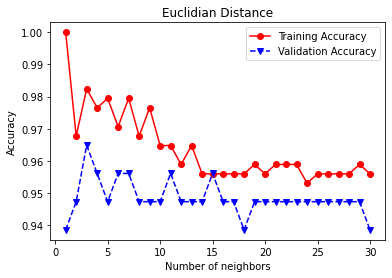

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

numNeighbors = range(1, 31)
trainAcc = []
valAcc = []

for k in numNeighbors:
    clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    clf.fit(X=X_train, y=y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predVal = clf.predict(X_val)
    trainAcc.append(accuracy_score(y_train, Y_predTrain))
    valAcc.append(accuracy_score(y_val, Y_predVal))

plt.plot(numNeighbors, trainAcc, 'ro-', numNeighbors, valAcc,'bv--')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.title('Euclidian Distance')

In class, we discussed other distance metrics that could be used besides Euclidean distance, such as absolute distance (Minkowski distance with order = 1) and cosine distance. Implement kNN and create the same plot as above, but using 1) absolute distance and 2) cosine distance. You will need to consult the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to find how to change the distance metric.

Absolute Distance


Text(0.5, 1.0, 'Absolute Distance')

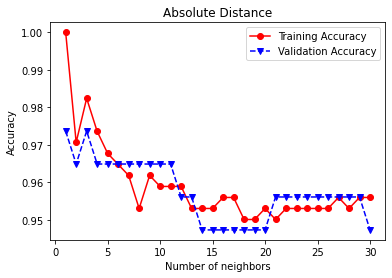

In [38]:
### Absolute distance ###
trainAcc = []
valAcc = []
print("Absolute Distance")
for k in numNeighbors:
    clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)
    clf.fit(X=X_train, y=y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predVal = clf.predict(X_val)
    trainAcc.append(accuracy_score(y_train, Y_predTrain))
    valAcc.append(accuracy_score(y_val, Y_predVal))

plt.plot(numNeighbors, trainAcc, 'ro-', numNeighbors, valAcc,'bv--')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.title('Absolute Distance')

Cosine Distance


Text(0.5, 1.0, 'Cosine Distance')

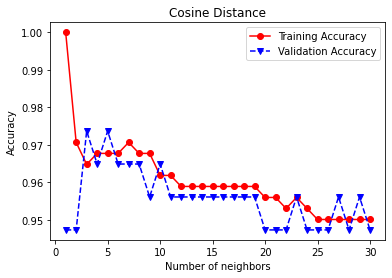

In [39]:
### Cosine distance ###
trainAcc = []
valAcc = []
print("Cosine Distance")
for k in numNeighbors:
    clf = KNeighborsClassifier(n_neighbors=k, metric='cosine', p=1)
    clf.fit(X=X_train, y=y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predVal = clf.predict(X_val)
    trainAcc.append(accuracy_score(y_train, Y_predTrain))
    valAcc.append(accuracy_score(y_val, Y_predVal))

plt.plot(numNeighbors, trainAcc, 'ro-', numNeighbors, valAcc,'bv--')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.title('Cosine Distance')

**Question 3: Which distance metric(s) gave the best overall accuracy on the validation set? You can refer to the highest validation accuracy achieved by each distance metric for this question.**

**Answer:**

According to above graphs,
both Absolute and Cosine have same highest validation accuracy of ~0.975.

### Weighted kNN
By default, kNN classifier in sklearn uses uniform weights---i.e., each neighbor is weighted equally when determining the class label based on the k nearest neighbors. Alternatively, we could weight the decision based on the distance of each neighbor from the test instance. Consult the documentation to figure out how to weight neighbors by their distance during prediction, then implement weighted kNN and generate the same plot as in the previous cells. Use absolute distance as the distance metric.

Absolute Distance


Text(0.5, 1.0, 'Absolute Distance')

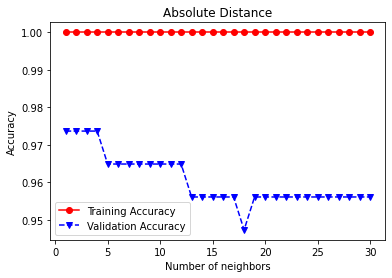

In [40]:
### Weighted kNN ###
trainAcc = []
valAcc = []
print("Absolute Distance")
for k in numNeighbors:
    clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1, weights = 'distance')
    clf.fit(X=X_train, y=y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predVal = clf.predict(X_val)
    trainAcc.append(accuracy_score(y_train, Y_predTrain))
    valAcc.append(accuracy_score(y_val, Y_predVal))

plt.plot(numNeighbors, trainAcc, 'ro-', numNeighbors, valAcc,'bv--')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.title('Absolute Distance')

To compute our final test accuracy, we'll choose a distance metric and number of neighbors that gave good performance on the validation set. Below, train a kNN model using Absolute Distance (L1 distance) and 3 neighbors (with uniform weights), then compute the test accuracy.

In [41]:
# YOUR CODE HERE
clf = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=1)
clf.fit(X=X_train, y=y_train)
y_pred = clf.predict(X_test)
testAcc = accuracy_score(y_test, y_pred)
print("Test Accuracy: {}".format(testAcc))

Test Accuracy: 0.9649122807017544
